In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
#%%capture
!unrar -s x 'drive/My Drive/DATASET_MED.rar' 'DATASET_MED' > ext_log.txt

In [2]:
!unzip -q 'drive/My Drive/data.zip' -d '.' > ext_log_small.txt

In [3]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB


In [23]:
%%capture
!pip install -U albumentations
!pip install efficientnet_pytorch

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
import pickle
from collections import defaultdict, OrderedDict
from tqdm.notebook import tqdm
import warnings
from IPython.display import clear_output


from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split


import skimage.transform
import cv2
from PIL import Image
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters


import albumentations as A
import albumentations.augmentations.functional as F
import albumentations.augmentations.transforms as T


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.autograd import Function
from torchvision import models, utils
from efficientnet_pytorch import EfficientNet

# Utils

In [2]:
# Plot roc curves and clalculate ROC-AUCs for all classes
def plot_roc_curves(y_true, y_pred, class_names):
    n_classes = len(class_names)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    threshold = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], threshold[i] = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    lw = 2
    # Plot all ROC curves
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'turquoise', 'teal', 'blue', 'red', 'black',
                    'lime', 'magenta', 'indigo', 'lavender', 'slateblue', 'deepskyblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label=f'ROC curve of class {class_names[i]} (area = {round(roc_auc[i], 2)})')

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC per each class in disease classification')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, threshold


# count model parameters to learn
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Get thresholds for all classes 
def get_thresholds(fpr, tpr, threshold):
    classes = fpr.keys()
    result = {}
    for class_number, fpr_class, tpr_class, threshold_class in zip(classes, fpr.values(), tpr.values(), threshold.values()):
        result[class_number] = {}
        conct_data_to_sort = np.concatenate(
            (np.expand_dims(np.abs(np.array(tpr_class) - 0.7), axis=1),
             np.expand_dims(tpr_class, axis=1),
             np.expand_dims(fpr_class, axis=1),
             np.expand_dims(threshold_class, axis=1)),
            axis=1,
            )
        conct_data_to_sort = sorted(conct_data_to_sort, key=lambda x: x[0])
        if conct_data_to_sort[0][-2] < 0.2:
            conct_data_to_sort = np.concatenate(
            (np.expand_dims(np.abs(np.array(fpr_class) - 0.2), axis=1),
             np.expand_dims(tpr_class, axis=1),
             np.expand_dims(fpr_class, axis=1),
             np.expand_dims(threshold_class, axis=1)),
            axis=1,
            )
            conct_data_to_sort = sorted(conct_data_to_sort, key=lambda x: x[0])
            result[class_number]['fpr'] = conct_data_to_sort[0][-2]
            result[class_number]['tpr'] = conct_data_to_sort[0][1]
            result[class_number]['threshold'] = conct_data_to_sort[0][-1]
        else:
          result[class_number]['fpr'] = conct_data_to_sort[0][-2]
          result[class_number]['tpr'] = conct_data_to_sort[0][1]
          result[class_number]['threshold'] = conct_data_to_sort[0][-1]
    return result


# Find real crit points 
def find_real_crit_points(polinomial, bounds):
    crit_points = polinomial.deriv().r
    real_crit_points = crit_points[crit_points.imag==0].real
    real_crit_points = real_crit_points[(real_crit_points<=bounds[-1]) & (real_crit_points>=bounds[0])]
    return real_crit_points[np.argmax(polinomial(real_crit_points))]


# Find threshold for class to maximize score = coef*TN + TP - FP - 2*FN 
def find_threshold_for_class(y_true, y_pred, thresholds_number, pol_degree=20, plot=False):
    tn_coef = sum(y_true)/sum(y_true == 0)
    result = {}
    t = np.linspace(0, 1, num=thresholds_number, endpoint=True)
    conf_matr = {'tn_arr':[],
                 'fp_arr': [],
                 'fn_arr': [],
                 'tp_arr': []
                 }
    tn_arr, fp_arr, fn_arr, tp_arr = [], [], [], []
    for threshold_t in tqdm(t):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= threshold_t).ravel()
        conf_matr['tn_arr'].append(tn)
        conf_matr['fp_arr'].append(fp)
        conf_matr['fn_arr'].append(fn)
        conf_matr['tp_arr'].append(tp)
    
    polinomial_dict = {}
    for key, value in conf_matr.items():
        polinomial = np.poly1d(np.polyfit(t, value, deg=pol_degree))
        polinomial_dict[f'{key[:2]}_pol'] = polinomial
        if plot:
            plt.plot(t, polinomial(t),'g-')
            plt.plot(t, value,'b')
            #print(polinomial)
            plt.ylim((np.min(value), np.max(value)))
            plt.xlim((np.min(t), np.max(t)))  
            plt.xlabel('threshold')
            plt.ylabel(key)
            plt.grid(True, which="both")
            plt.show()
    
    score_polinomial = polinomial_dict['tp_pol'] - 2*polinomial_dict['fn_pol'] - polinomial_dict['fp_pol'] + tn_coef*polinomial_dict['tn_pol']
    return find_real_crit_points(score_polinomial, (0, 1))

# Dataloader

In [3]:
RANDOM_SEED = 42
VALID_SIZE = 0.1

class ChestXrayDataSet(Dataset):
    def __init__(self, data_dir, image_list_file, train_or_valid='train', transform=None):
        """
        Args:
            data_dir: path to image directory.
            image_list_file: file name containing images
                with corresponding labels.
            train_or_valid: train or valid dataset
            transform: optional transform to be applied on a sample.
        """
        if train_or_valid != 'train' and train_or_valid != 'valid':
            raise ValueError(f'{train_or_valid} parameter is incorrect')

        if 'labels' in image_list_file:
            data_file = pd.read_csv(os.path.join(data_dir, image_list_file), names=['name', 'label'], header=0)
            image_names = list(data_file['name'])
            bboxes = None
            class_names = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                                    'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
        elif 'bbox' in image_list_file:
            data_file = pd.read_csv(os.path.join(data_dir, image_list_file), names=['name', 'label', 'x', 'y', 'w', 'h'], header=0)
            image_names = list(data_file['name'])
            bboxes = np.array(data_file[['x', 'y', 'w', 'h']])
            class_names = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate',
                                    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax'])
        
        self.class_names = class_names
        self.data_dir = data_dir
        self.transform = transform

        labels = list(data_file['label'].map(lambda x: self.one_hot(x.split('|'))))

        data = {}
        if bboxes is not None:
            data['image_names_train'], data['image_names_valid'], data['labels_train'], \
             data['labels_valid'], data['bboxes_train'], data['bboxes_valid'] = train_test_split(
                image_names,
                labels,
                bboxes,
                test_size=VALID_SIZE,
                random_state=RANDOM_SEED,
                stratify=np.sum(labels, axis=1))
        else:
            data['image_names_train'], data['image_names_valid'], \
             data['labels_train'], data['labels_valid'] = train_test_split(
                image_names,
                labels,
                test_size=VALID_SIZE,
                random_state=RANDOM_SEED,
                #stratify=np.sum(labels, axis=1)
                )
        
        self.image_names = data[f'image_names_{train_or_valid}']
        self.labels = data[f'labels_{train_or_valid}']
        if bboxes is not None:
            self.bboxes = data[f'bboxes_{train_or_valid}'] # x, y, w, h (x, y - upper left corner)
        else:
            self.bboxes = bboxes

    def one_hot(self, labels_list):
        result = np.zeros(len(self.class_names))
        for label in labels_list:
            result[np.where(label==self.class_names)[0]] += 1
        return result.astype(int)

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_names[index]
        image = Image.open(os.path.join(self.data_dir, 'Images', image_name)).convert('RGB')
        #image = cv2.imread(os.path.join(self.data_dir, 'Images', image_name))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        
        if self.bboxes is not None:
            bbox = self.bboxes[index]
            return image, torch.FloatTensor(label), torch.FloatTensor(bbox)
        else:
            return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)


# Transforms
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

transforms_train = transforms.Compose([transforms.Resize(256),
                                       transforms.TenCrop(224),
                                       transforms.Lambda(
                                           lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])
                                           ),
                                       transforms.Lambda(
                                           lambda crops: torch.stack([transforms.RandomHorizontalFlip()(crop) for crop in crops])
                                           ),
                                       transforms.Lambda(
                                           lambda crops: torch.stack([normalize(crop) for crop in crops])
                                           ),
                                       transforms.Lambda(
                                           lambda crops: torch.stack([transforms.RandomErasing()(crop) for crop in crops])
                                           ),
                                       ])
transforms_valid = transforms.Compose([transforms.Resize(256),
                                       transforms.TenCrop(224),
                                       transforms.Lambda(
                                           lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])
                                           ),
                                       transforms.Lambda(
                                           lambda crops: torch.stack([normalize(crop) for crop in crops])
                                           ),
                                       ])

DATA_DIR_BBOX = 'DATASET_MED/With_bbox'
IMAGE_LIST_BBOX = 'With_bbox.csv'
DATA_DIR_LABELS = 'DATASET_MED/Only_labels'
IMAGE_LIST_LABELS = 'Only_labels.csv'
BATCH_SIZE = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


bboxes_dataset_train = ChestXrayDataSet(DATA_DIR_BBOX, IMAGE_LIST_BBOX, 'train', transforms_train)
labels_dataset_train = ChestXrayDataSet(DATA_DIR_LABELS, IMAGE_LIST_LABELS, 'train', transforms_train)
bboxes_dataset_valid = ChestXrayDataSet(DATA_DIR_BBOX, IMAGE_LIST_BBOX, 'valid', transforms_valid)
labels_dataset_valid = ChestXrayDataSet(DATA_DIR_LABELS, IMAGE_LIST_LABELS, 'valid', transforms_valid)


bboxes_dataset_dataloader_train = DataLoader(dataset=bboxes_dataset_train, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=1, pin_memory=True)
bboxes_dataset_dataloader_valid = DataLoader(dataset=bboxes_dataset_valid, batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=1, pin_memory=True)
labels_dataset_dataloader_train = DataLoader(dataset=labels_dataset_train, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=1, pin_memory=True)
labels_dataset_dataloader_valid = DataLoader(dataset=labels_dataset_valid, batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=1, pin_memory=True)

In [4]:
bboxes_dataset_visual = ChestXrayDataSet(DATA_DIR_BBOX, IMAGE_LIST_BBOX, 'train')
labels_dataset_visual = ChestXrayDataSet(DATA_DIR_LABELS, IMAGE_LIST_LABELS, 'train')


def visualize_data(dataset):
    dataset_len = len(dataset)
    sample = np.random.choice(dataset_len, 6, replace=False)
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(21, 15))
    for row_idx, row in enumerate(ax):
        for col_idx, col in enumerate(row):
            idx = row_idx*3 + col_idx*1
            data = dataset[sample[idx]]
            if len(data) == 2:
                image, label = data
                disease_names_array = dataset.class_names[label.cpu().numpy().astype(bool)]
            elif len(data) == 3:
                image, label, bbox = data
                x, y, w, h = np.around(bbox.cpu().numpy()).astype(int)
                image = cv2.rectangle(np.array(image), (x, y), (x + w, y + h), (36,255,12), 1)
                disease_names_array = dataset.class_names[label.cpu().numpy().astype(bool)]
                disease_name = '\n'.join(disease_names_array)
                cv2.putText(image, disease_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

            if len(disease_names_array) == 0:
                disease_names_array = np.array(['No Finding'])
            disease_names = ''
            for disease_number, disease_name in enumerate(disease_names_array):
                if disease_number == 0:
                    disease_names += disease_name
                elif disease_number % 3 == 0:
                    disease_names += f'\n {disease_name}'
                else:
                    disease_names += f', {disease_name}'
            col.imshow(image)
            col.set_title(disease_names, color='black')

    plt.show()
    return None

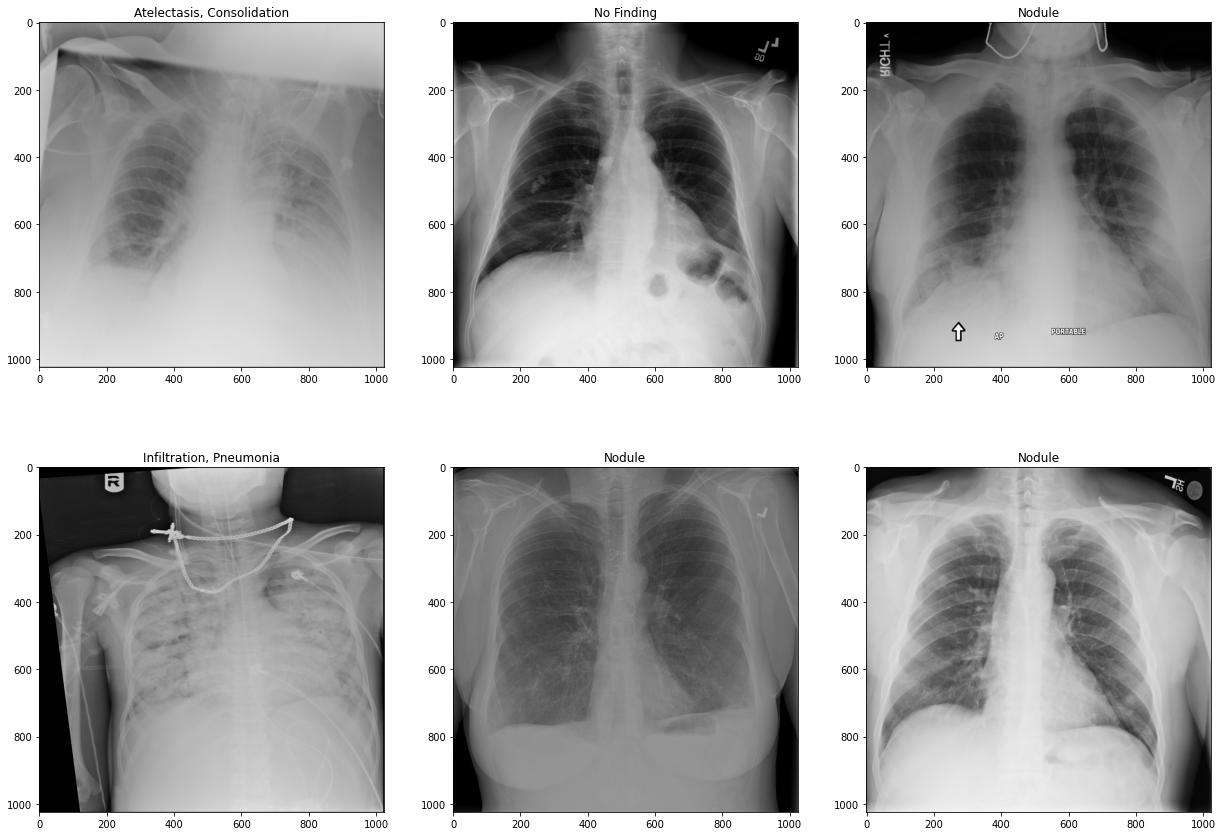

In [5]:
visualize_data(labels_dataset_visual)

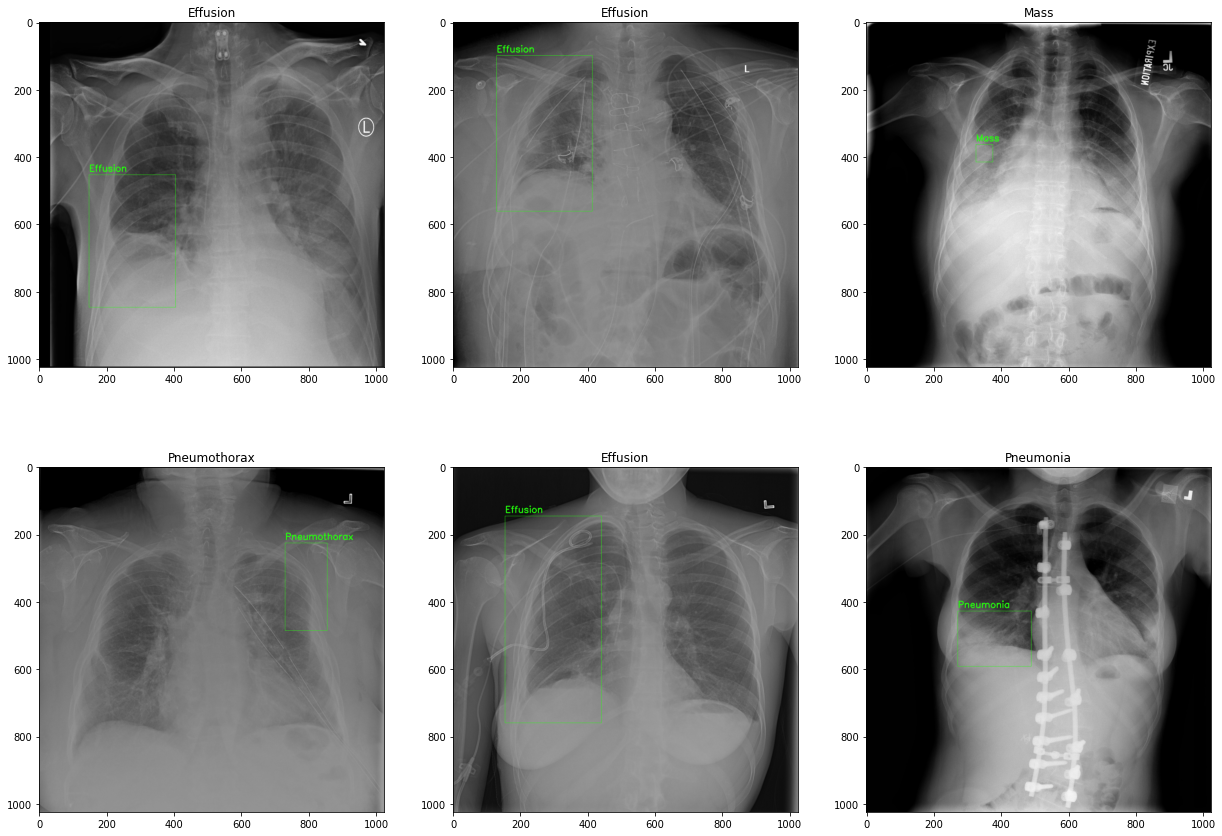

In [6]:
visualize_data(bboxes_dataset_visual)

# Model

In [7]:
CLASS_NAMES = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion',
                        'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                        'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema',
                        'Fibrosis', 'Pleural_Thickening', 'Hernia'])
N_CLASSES = len(CLASS_NAMES)


class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [8]:
torch.cuda.empty_cache()
model = DenseNet121(N_CLASSES).to(device)

torch.cuda.empty_cache()
CKPT_PATH = '/models/densnet_best.pth'


if os.path.isfile(CKPT_PATH):
    print("=> loading checkpoint")
    state_dict = torch.load(CKPT_PATH)
    model.load_state_dict(state_dict)
    print("=> loaded checkpoint")
else:
    print("=> no checkpoint found")

=> loading checkpoint
=> loaded checkpoint


# Training loop

In [9]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.target_container = []
        self.output_container = []
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def add(self, output, target):
        if isinstance(output, list) and isinstance(target, list):
            self.output_container.extend(output)
            self.target_container.extend(target)
        else:
            raise ValueError(f'Output and target must have list format, but got {type(output)} and {type(target)}')

    def __str__(self):
        return " | ".join(
            [
                f'{metric_name}: {metric["avg"]:.{self.float_precision}f}'
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [10]:
def train(train_loader, model, criterion, optimizer, scheduler, epoch, plot_other_graphics, data_dict):
    metric_monitor = MetricMonitor()
    losses = []
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        bs, n_crops, c, h, w = images.size() 
        images = images.view(-1, c, h, w).to(device, non_blocking=True)
        target = target.repeat((1, n_crops)).view((-1, N_CLASSES))
        target = target.to(device, non_blocking=True).float()
        output = model(images)
        loss = criterion(output, target)
        
        metric_monitor.update("Loss", loss.item())
        metric_monitor.add(output.cpu().detach().numpy().tolist(),
                           target.cpu().detach().numpy().tolist())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            f'Epoch: {epoch}. Train.      {metric_monitor}'
        )
        losses.append(loss.cpu().detach().numpy())
        if i % 100 == 0:
          scheduler.step()
          data_dict['train_loss'].append(np.array(losses)[-100:].mean())
          clear_output(True)
          if ('valid_loss' in data_dict.keys() and len(data_dict['valid_loss'])==0) or ('valid_loss' not in data_dict.keys()):
              fig, ax = plt.subplots(1, 1, figsize = (15, 5))
              ax.plot(data_dict['train_loss'], label='train loss')
          else:
              fig, ax = plt.subplots(1, 2, figsize = (15, 5))
              ax[0].plot(data_dict['train_loss'], label='train loss')
              ax[1].plot(data_dict['valid_loss'], label='valid loss')
          plt.show()
          if plot_other_graphics:
              plot_other_graphics()
    return metric_monitor, data_dict



def validate(val_loader, model, criterion, epoch, plot_other_graphics, data_dict):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    losses = []
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            bs, n_crops, c, h, w = images.size() 
            images = images.view(-1, c, h, w).to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float()
            output = model(images)
            output_mean = output.view(bs, n_crops, -1).mean(1)
            loss = criterion(output_mean, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.add(output_mean.cpu().detach().numpy().tolist(),
                               target.cpu().detach().numpy().tolist())
            stream.set_description(
                f'Epoch: {epoch}. Validation. {metric_monitor}'
            )
            losses.append(loss.cpu().detach().numpy())
            if i % 50 == 0:
              data_dict['valid_loss'].append(np.array(losses)[-50:].mean())
              clear_output(True)
              if ('train_loss' in data_dict.keys() and len(data_dict['train_loss'])==0) or ('train_loss' not in data_dict.keys()):
                  fig, ax = plt.subplots(1, 1, figsize = (15, 5))
                  ax.plot(data_dict['valid_loss'], label='valid loss')
              else:
                  fig, ax = plt.subplots(1, 2, figsize = (15, 5))
                  ax[0].plot(data_dict['train_loss'], label='train loss')
                  ax[1].plot(data_dict['valid_loss'], label='valid loss')
              plt.show()
              if plot_other_graphics:
                  plot_other_graphics()
    return metric_monitor, data_dict

In [11]:
n_epochs = 5
lr = 2e-5
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.99, last_epoch=-1)

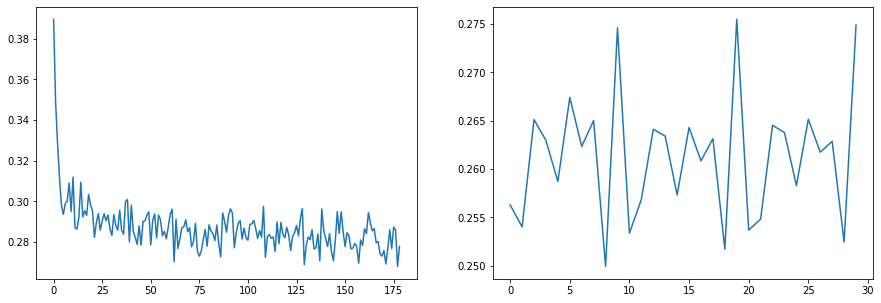

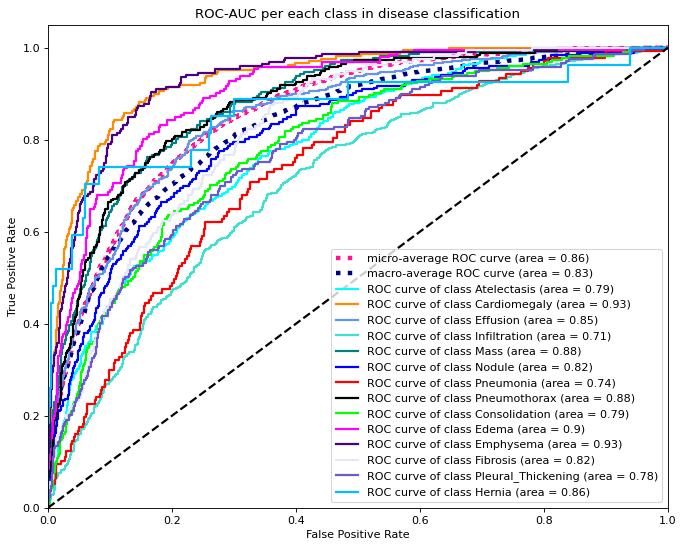

In [ ]:
data_dict = {'train_loss': [],
             'valid_loss': []}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for epoch in range(1, n_epochs + 1):
        if epoch != 1:
            def plot_other_graphics():
                plot_roc_curves(np.array(metric_monitor_valid.target_container),
                                np.array(metric_monitor_valid.output_container),
                                CLASS_NAMES)
        else:
            plot_other_graphics = None
        metric_monitor_train, data_dict = train(labels_dataset_dataloader_train, model, criterion,
                                                optimizer, scheduler, epoch, plot_other_graphics, data_dict)
        metric_monitor_valid, data_dict = validate(labels_dataset_dataloader_valid, model, criterion,
                                                   epoch, plot_other_graphics, data_dict)
        torch.save(model.state_dict(), f'/content/drive/My Drive/model_epoch_{epoch}_new.pth')

        #clear_output(wait=True)
    

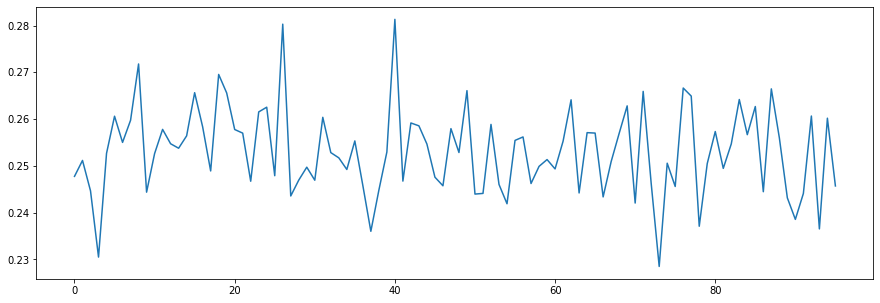

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


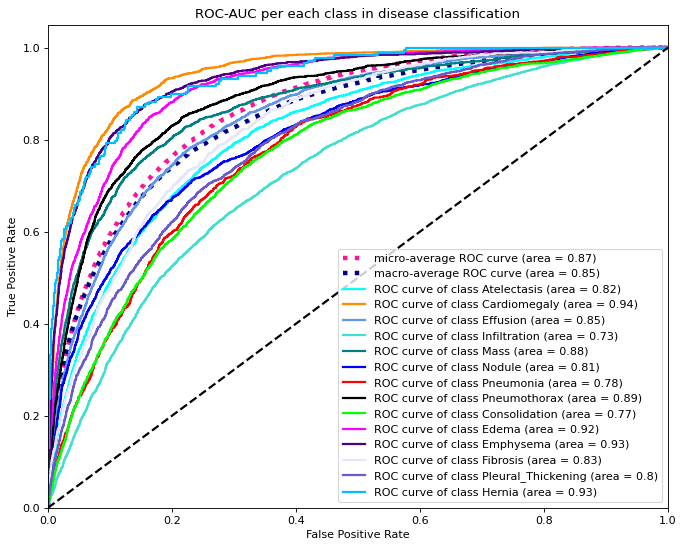

In [20]:
data_dict = data_dict = {'train_loss': [],
                         'valid_loss': []}
metric_monitor_valid, data_dict = validate(labels_dataset_dataloader_train, model, criterion,
                                           0, None, data_dict)
_, _, _ = plot_roc_curves(np.array(metric_monitor_valid.target_container),
                          np.array(metric_monitor_valid.output_container),
                          CLASS_NAMES)

In [25]:
threshold_sc_14 = []
for i in tqdm(range(14)):
    threshold_sc_14.append(find_threshold_for_class(np.array(metric_monitor_valid.target_container)[:, i],
                                                    np.array(metric_monitor_valid.output_container)[:, i], 1001))

with open('threshold_sc_14_densnet.pkl', 'wb') as f:
    pickle.dump(threshold_sc_14, f)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


# Efficient Net


In [12]:
%%capture
class EfficientNetModel(nn.Module):

    def __init__(self, out_size):
        super(EfficientNetModel, self).__init__()

        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b3')
        fltrs = self.efficient_net._fc.in_features
        self.efficient_net._fc = nn.Sequential(
                                                nn.Linear(in_features=fltrs, out_features=out_size, bias=True),
                                                nn.Sigmoid()
                                                )
       # self.efficient_net._swish = nn.Softmax()

    def forward(self, x):
        x = self.efficient_net(x)
        return x

model_net = EfficientNetModel(N_CLASSES)
model_net.to(device)

In [13]:
torch.cuda.empty_cache()
CKPT_PATH = '/models/efficientnet_best.pth'


if os.path.isfile(CKPT_PATH):
    print("=> loading checkpoint")
    state_dict = torch.load(CKPT_PATH)
    model_net.load_state_dict(state_dict)
    print("=> loaded checkpoint")
else:
    print("=> no checkpoint found")

=> loading checkpoint
=> loaded checkpoint


In [14]:
n_epochs = 20
lr = 5e-7
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model_net.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.99, last_epoch=-1)

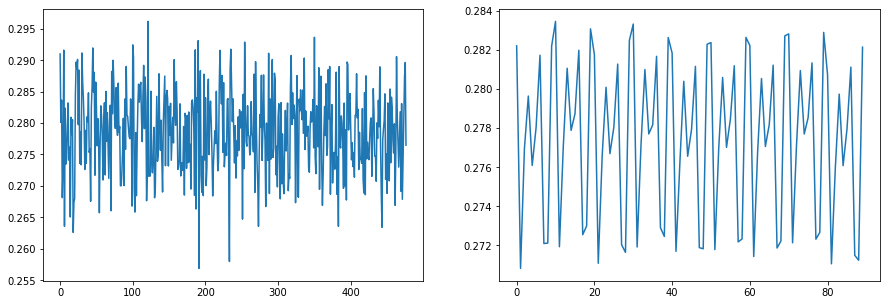

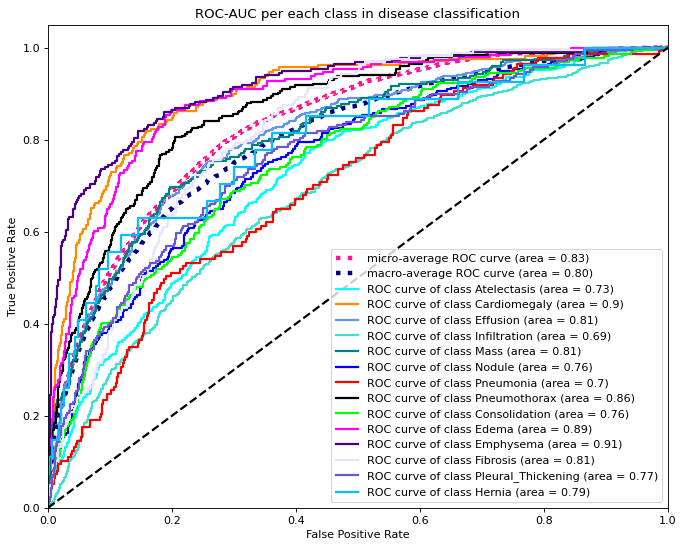

In [ ]:
data_dict = {'train_loss': [],
             'valid_loss': []}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for epoch in range(11, n_epochs + 1):
        if epoch != 11:
            def plot_other_graphics():
                plot_roc_curves(np.array(metric_monitor_valid.target_container),
                                np.array(metric_monitor_valid.output_container),
                                CLASS_NAMES)
        else:
            plot_other_graphics = None
        metric_monitor_train, data_dict = train(labels_dataset_dataloader_train, model_net, criterion,
                                                optimizer, scheduler, epoch, plot_other_graphics, data_dict)
        metric_monitor_valid, data_dict = validate(labels_dataset_dataloader_valid, model_net, criterion,
                                                   epoch, plot_other_graphics, data_dict)
        torch.save(model_net.state_dict(), f'/content/drive/My Drive/model_net_epoch_{epoch}_new.pth')

        #clear_output(wait=True)
    

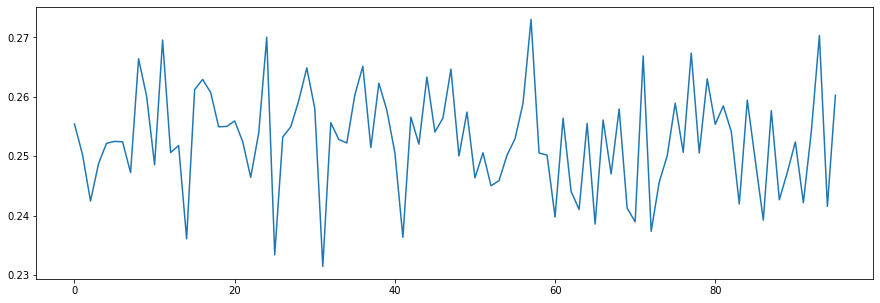

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


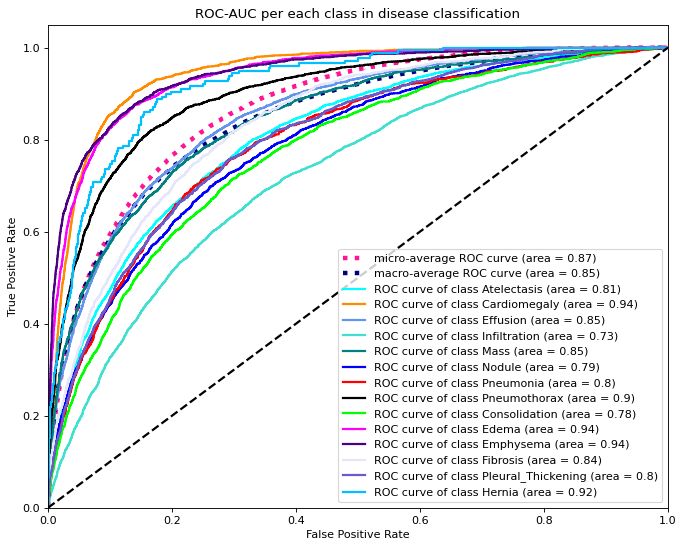

In [29]:
data_dict = data_dict = {'train_loss': [],
                         'valid_loss': []}
metric_monitor_valid, data_dict = validate(labels_dataset_dataloader_train, model_net, criterion,
                                           0, None, data_dict)
_, _, _ = plot_roc_curves(np.array(metric_monitor_valid.target_container),
                          np.array(metric_monitor_valid.output_container),
                          CLASS_NAMES)

In [30]:
threshold_sc_14_net = []
for i in tqdm(range(14)):
    threshold_sc_14_net.append(find_threshold_for_class(np.array(metric_monitor_valid.target_container)[:, i],
                                                        np.array(metric_monitor_valid.output_container)[:, i], 1001))

with open('threshold_sc_14_effnet.pkl', 'wb') as f:
    pickle.dump(threshold_sc_14_net, f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


# GRAD-Cam

In [16]:
# ======= Grad CAM Function =========
class PropagationBase(object):

    def __init__(self, model, device):
        self.model = model.to(device)
        self.model.eval()
        self.device = device
        self.all_fmaps = OrderedDict()
        self.all_grads = OrderedDict()
        self._set_hook_func()
        self.image = None

    def _set_hook_func(self):
        raise NotImplementedError

    def _encode_one_hot(self, idx):
        one_hot = torch.FloatTensor(1, self.preds.size()[-1]).zero_()
        one_hot[0][idx] = 1.0
        return one_hot.to(self.device)

    def forward(self, image):
        self.image = image
        self.preds = self.model(self.image)
        self.repeat_times = self.preds.shape[0]
        return self.preds.cpu().data.numpy()

    def backward(self, idx):
        self.model.zero_grad()
        one_hot = self._encode_one_hot(idx).repeat((self.repeat_times, 1))
        self.preds.backward(gradient=one_hot, retain_graph=True)


class GradCAM(PropagationBase):

    def _set_hook_func(self):

        def func_f(module, input, output):
            self.all_fmaps[id(module)] = output.data.cpu()

        def func_b(module, grad_in, grad_out):
            self.all_grads[id(module)] = grad_out[0].cpu()

        for module in self.model.named_modules():
            module[1].register_forward_hook(func_f)
            module[1].register_backward_hook(func_b)

    def _find(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError('Invalid layer name: {}'.format(target_layer))

    def _normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.data

    def _compute_grad_weights(self, grads):
        grads = self._normalize(grads)
        self.map_size = grads.size()[2:]
        return nn.AvgPool2d(self.map_size)(grads)

    def generate(self, target_layer):
        fmaps = self._find(self.all_fmaps, target_layer)
        grads = self._find(self.all_grads, target_layer)
        weights = self._compute_grad_weights(grads)
        gcam = torch.FloatTensor(self.map_size).zero_()
        for fmap, weight in zip(fmaps[0], weights[0]):
            gcam += fmap * weight.data
        
        gcam = F.relu(Variable(gcam))

        gcam = gcam.data.cpu().numpy()
        gcam -= gcam.min()
        gcam /= gcam.max()
        gcam = cv2.resize(gcam, (self.image.size(3), self.image.size(2)))

        return gcam

    def save(self, filename, gcam, raw_image):
        gcam = cv2.applyColorMap(np.uint8(gcam * 255.0), cv2.COLORMAP_JET)
        gcam = gcam.astype(np.float) + raw_image.astype(np.float)
        gcam = gcam / gcam.max() * 255.0
        cv2.imwrite(filename, np.uint8(gcam))

# Heatmaps

In [17]:
gcam_densnet = GradCAM(model=model, device=device)
gcam_efficientnet = GradCAM(model=model_net, device=device)

densenet_target_layer = 'densenet121.features.denseblock4.denselayer16.conv2'
efficientnet_target_layer = 'efficient_net._conv_head'

def get_heatmaps(gcam, indexes, thresholds, model_type, bboxes_dataset, target_layer):
    result = {}
    for index in tqdm(indexes):
        result[index] = {}
        img, label, bbox = bboxes_dataset[index]
        result[index]['label'] = label.unsqueeze(0).cpu().numpy()
        result[index]['bbox'] = bbox

        if model_type == '14':
            n_crops, c, h, w = img.size()
            input_var = img.view(-1, c, h, w).to(device)
            input_img = Variable(input_var, requires_grad=True)
        elif model_type == '8':
            input_img = Variable((img).unsqueeze(0).to(device), requires_grad=True)
        
        probs = gcam.forward(input_img)

        if model_type == '14':
            probs = np.expand_dims(probs.mean(axis=0), 0)

        if probs.shape[-1] > 8:
            probs = probs[:,:8]
        elif probs.shape[-1] < 8:
            raise ValueError('model is not right')
        result[index]['probs'] = probs
        result[index]['activated_classes'] = (probs > thresholds).astype(int).squeeze(0)

        activate_classes = np.where((probs > thresholds)[0]==True)[0]

        result[index]['heatmap_output'] = {}
        for activate_class in activate_classes:
            gcam.backward(idx=activate_class)
            output = gcam.generate(target_layer=target_layer)
            if np.sum(np.isnan(output)) > 0:
                print("fxxx nan")
            else:
                result[index]['heatmap_output'][activate_class] = output
    return result

In [18]:
img_width, img_height = 224, 224
img_width_exp, img_height_exp = 1024, 1024
crop_del = 16
rescale_factor = 4

avg_size = np.array([[411.8, 512.5, 219.0, 139.1], [348.5, 392.3, 479.8, 381.1],
                     [396.5, 415.8, 221.6, 318.0], [394.5, 389.1, 294.0, 297.4],
                     [434.3, 366.7, 168.7, 189.8], [502.4, 458.7, 71.9, 70.4],
                     [378.7, 416.7, 276.5, 304.5], [369.3, 209.4, 198.9, 246.0]])

with open('threshold_sc_14_densnet.pkl', 'rb') as f:
    threshold_sc_14 = pickle.load(f)

with open('threshold_sc_14_effnet.pkl', 'rb') as f:
    threshold_sc_14_net = pickle.load(f)


def get_bbox_for_heatmap(heatmap, class_number):

    result = {'average_prediction': {'x': avg_size[class_number][0],
                                     'y': avg_size[class_number][1],
                                     'w': avg_size[class_number][2],
                                     'h': avg_size[class_number][3]}
    }
    if np.isnan(heatmap).any():
        return ValueError("all nan's")

    w, h = (avg_size[class_number][2:4] * (256 / 1024)).astype(int)
    
    # Find local maxima
    neighborhood_size = 100
    threshold = .1
    
    heatmap_max = filters.maximum_filter(heatmap, neighborhood_size)
    maxima = (heatmap == heatmap_max).astype(int)
    heatmap_min = filters.minimum_filter(heatmap, neighborhood_size)
    diff = ((heatmap_max - heatmap_min) > threshold).astype(int)
    maxima[diff == 0] = 0
    for _ in range(5):
        maxima = ndimage.binary_dilation(maxima).astype(int)
    labeled, num_objects = ndimage.label(maxima)
    # slices = ndimage.find_objects(labeled)
    centers_of_masses = np.array(ndimage.center_of_mass(heatmap, labeled, range(1, num_objects+1)))
    for idx, point in enumerate(centers_of_masses):
        if heatmap[int(point[0]), int(point[1])] > np.max(heatmap)*0.9:
            upper = int(max(point[0]-(h/2), 0.))
            left = int(max(point[1]-(w/2), 0.))
            right = int(min(left+w, img_width))
            lower = int(min(upper+h, img_height))
            result.update({f'bbox_prediction_{idx}': {
                'x': (left+crop_del)*rescale_factor,
                'y': (upper+crop_del)*rescale_factor,
                'w': (right-left)*rescale_factor,
                'h': (lower-upper)*rescale_factor}
                })

    return result


def get_bboxes_for_heatmaps(heatmaps):
    result = {}
    for idx, heatmap_data in heatmaps.items():
        result[idx] = {'true_bbox': heatmap_data['bbox'],
                       'true_label': heatmap_data['label'],
                       'activated_classes': heatmap_data['activated_classes'],
                       'pred_bbox': {}}
        for class_number, heatmap in heatmap_data['heatmap_output'].items():
            result[idx]['pred_bbox'][class_number] = get_bbox_for_heatmap(heatmap, class_number)
            result[idx]['pred_bbox'][class_number]['heatmap'] = heatmap
    return result


def get_img(ind, dataset):
    img = Image.open(os.path.join(dataset.data_dir, 'Images',
                            dataset.image_names[ind])).convert('RGB')
    return np.array(img).astype('int')

In [19]:
ids = [2]
img = get_img(2, bboxes_dataset_train)
heatmaps_densnet = get_heatmaps(gcam_densnet, ids, np.array(threshold_sc_14)[:8], '14', bboxes_dataset_train, densenet_target_layer)
prepared_data_densnet = get_bboxes_for_heatmaps(heatmaps_densnet)
heatmaps_efficientnet = get_heatmaps(gcam_efficientnet, ids, np.array(threshold_sc_14)[:8], '14', bboxes_dataset_train, efficientnet_target_layer)
prepared_data_efficientnet = get_bboxes_for_heatmaps(heatmaps_efficientnet)

In [20]:
def get_pic_title(disease_names_array):
    if len(disease_names_array) == 0:
        disease_names_array = np.array(['No Finding'])
    disease_names = ''
    for disease_number, disease_name in enumerate(disease_names_array):
        if disease_number == 0:
            disease_names += disease_name
        elif disease_number % 3 == 0:
            disease_names += f'\n {disease_name}'
        else:
            disease_names += f', {disease_name}'
    return disease_names

def print_heatmap_and_bbox(model_data, img, bboxes_dataset):
    x_true, y_true, w_true, h_true = np.around(model_data['true_bbox'].cpu().numpy()).astype(int)
    gt_label = np.squeeze(model_data['true_label'])
    pred_label = model_data['activated_classes']
    disease_names_array_pred = bboxes_dataset.class_names[pred_label.astype(bool)]
    disease_names_array_true = bboxes_dataset.class_names[gt_label.astype(bool)]
    pic_title_true = get_pic_title(disease_names_array_true)
    pic_title_pred = get_pic_title(disease_names_array_pred)

    # True pic
    img_true = cv2.rectangle(img, (x_true, y_true), (x_true + w_true, y_true + h_true), (36,255,12), 1)
    disease_name_true = '\n'.join(disease_names_array_true)
    cv2.putText(img_true, disease_name_true, (x_true, y_true-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    fig, ax = plt.subplots(1, 2, figsize = (10, 10))
    ax[0].imshow(cv2.UMat.get(img_true))
    ax[0].set_title(pic_title_true, color='black')

    # Pred pic
    img_pred = img
    for class_num, heatmap_data in model_data['pred_bbox'].items():
        class_name = bboxes_dataset.class_names[class_num]
        bboxes_for_class = list(filter(lambda x: 'bbox_prediction_' in x, heatmap_data.keys()))
        for bbox_name in sorted(bboxes_for_class)[:1]:
            bbox = heatmap_data[bbox_name]
            img_pred = cv2.rectangle(img_pred, (bbox['x'], bbox['y']), (bbox['x'] + bbox['w'], bbox['y'] + bbox['h']), (36,255,12), 1)
            cv2.putText(img_pred, class_name, (bbox['x'], bbox['y']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    ax[1].imshow(cv2.UMat.get(img_pred), label='valid loss')
    ax[1].set_title(pic_title_pred, color='black')
    fig = plt.figure(figsize=(15, 15))
    columns = 3
    rows = 3
    for idx, (class_num, heatmap_data) in enumerate(model_data['pred_bbox'].items()):
        class_name = bboxes_dataset.class_names[class_num]
        ax = fig.add_subplot(rows, columns, idx+1)
        ax.set_title(class_name, color='black')
        ax.imshow(heatmap_data['heatmap'])
    plt.show()

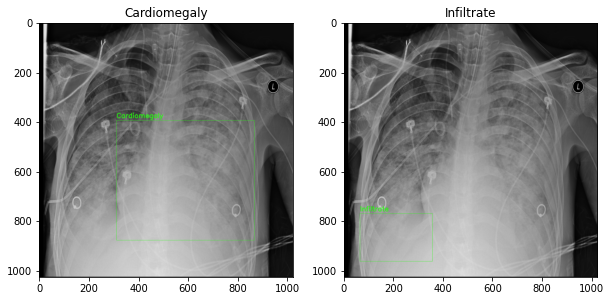

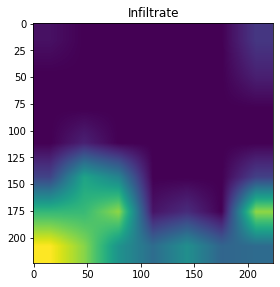

In [21]:
print_heatmap_and_bbox(prepared_data_densnet[ids[0]], img, bboxes_dataset_train)

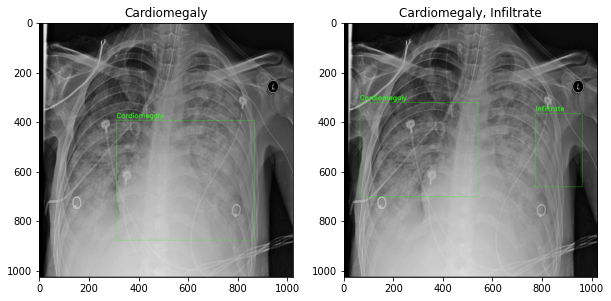

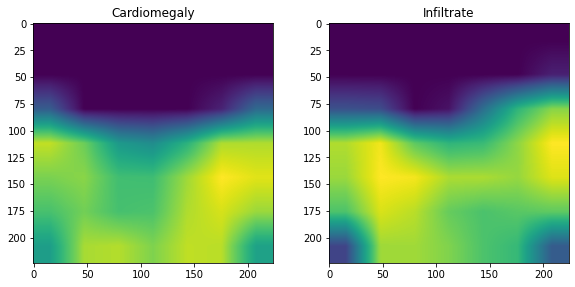

In [22]:
print_heatmap_and_bbox(prepared_data_efficientnet[ids[0]], img, bboxes_dataset_train)

# Inference

In [62]:
!curl --location --request POST 'http://dc4c11f6a859.ngrok.io/submit_densnet' \
--form 'file=@/DATASET_MED/Only_labels/Images/2000657.png' \
--form 'file=@/DATASET_MED/Only_labels/Images/2002066.png' 



{"Labels":["Atelectasis","Atelectasis, Cardiomegaly, Mass, Hernia"],"id":["2000657.png","2002066.png"]}


In [65]:
!curl --location --request POST 'http://dc4c11f6a859.ngrok.io/submit_effnet' \
--form 'file=@/DATASET_MED/Only_labels/Images/2000657.png' \
--form 'file=@/DATASET_MED/Only_labels/Images/2002066.png' 


{"Labels":["Atelectasis","Atelectasis, Cardiomegaly, Hernia"],"id":["2000657.png","2002066.png"]}
